# Multigroup Gaussian Processes

In [1]:
import os
import matplotlib.pyplot as plt
import torch
import numpy as np


import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist

from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [57]:
pyro.set_rng_seed(3)

noise_variance = torch.tensor(0.05)
n0, n1 = 100, 100


X0 = dist.Uniform(-10, 10).sample(sample_shape=(n0,))
X1 = dist.Uniform(-10, 10).sample(sample_shape=(n1,))

X = torch.concatenate([X0, X1], axis=0)

In [58]:
X_groups = torch.concatenate([torch.zeros(n0), torch.ones(n1)]).type(torch.LongTensor)

In [59]:
kernel_true = gp.kernels.MultiGroupRBF(input_dim=1, variance=torch.tensor(1), lengthscale=torch.tensor(1), group_diff_param=torch.tensor(1))
cov = kernel_true.forward(X=X, groupsX=X_groups)+noise_variance.expand(n0+n1).diag()
Y = dist.MultivariateNormal(torch.zeros_like(X), cov).sample()

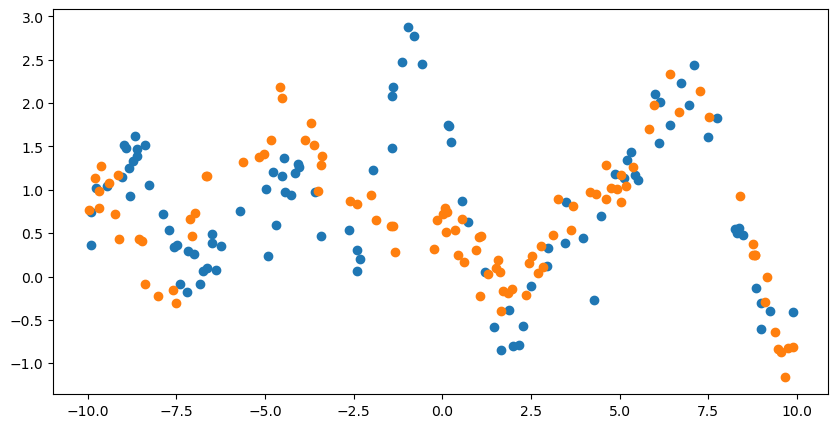

In [60]:
plt.figure(figsize=(10, 5))
plt.scatter(X0, Y[:n0])
plt.scatter(X1, Y[n0:])